<a href="https://colab.research.google.com/github/HKimura787/blog/blob/main/Qitta/kubobook_icar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 実行環境の整備・ライブラリインポート

In [1]:
# GoogleColabで実行

# stanとlibpysalの準備
!pip install cmdstanpy libpysal
import cmdstanpy
cmdstanpy.install_cmdstan()

# pymcのアップデート
!pip install pymc -U # 5.7.2にはICARがないので最新版にアップデート（5.10.0ではICARがあることを確認）

# 緑本のデータをダウンロード・展開
!wget https://kuboweb.github.io/-kubo/stat/iwanamibook/kubobook_2012.zip
!unzip kubobook_2012.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 17.6 MB/s eta 0:00:00
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.33.1
Download successful, file: /tmp/tmp3q2n_zpb
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.33.1
Building version cmdstan-2.33.1, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.33.1
Test model compilation
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.1/470.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2
--2023-12-01 13:23:29--  https://kuboweb.github.io/-kubo/stat/iwanamibook/kubobook_2012.zip
Resolving kuboweb.github.io (kuboweb.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to kuboweb.github.io (kuboweb.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27415245 (26M) [application/zip]
Saving to: ‘kubobook_2012.zip’

kubobook_2012.zip   100%[===================>]  26.14M  --.-KB/s    in 0.07s   

In [2]:
# 全体的に使うパッケージのインポート
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-white")
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## データのインポート

In [3]:
# # RDataからデータの取り出し
# import rpy2.robjects as ro
# ro.r("load('/content/kubobook_2012/spatial/Y.RData')")

# # RのベクトルをNumPyアレイに変換
# Y_data = np.array(ro.r('Y'))
# m_data = np.array(ro.r('m'))

In [4]:
# WARNING:rpy2.rinterface_lib.callbacks:R[write to console]: Error: ignoring SIGPIPE signal
# RDataから直接データを読み込むとPyMCのサンプリング終了時に上記のエラーが出るのでデータをベタ書きしている
# Stanではrpy2を使ってRDataから直接データを読み込んでも問題ない

Y_data=np.array([0, 3, 2, 5, 6, 16, 8, 14, 11, 10, 17, 19, 14, 19, 19, 18, 15, 13, 13, 9, 11, 15, 18, 12, 11, 17, 14, 16, 15, 9, 6, 15, 10, 11, 14, 7, 14, 14, 13, 17, 8, 7, 10, 4, 5, 5, 7, 4, 3, 1])
m_data = np.array([
    2.154980,  3.254165,  4.628666,  6.234124,  7.990730,  9.794474, 11.533365, 13.104252,
    14.426302, 15.448779, 16.152648, 16.547110, 16.662963, 16.544787, 16.243533, 15.810516,
    15.293192, 14.732666, 14.162655, 13.609478, 13.092706, 12.626139, 12.218880, 11.876341,
    11.601109, 11.393614, 11.252589, 11.175337, 11.157802, 11.194468, 11.278111, 11.399429,
    11.546588, 11.704760, 11.855733, 11.977728, 12.045594, 12.031548, 11.906676, 11.643296,
    11.218186, 10.616465,  9.835614,  8.888846,  7.806816,  6.636728,  5.438219,  4.276194,
    3.211708,  2.292856])

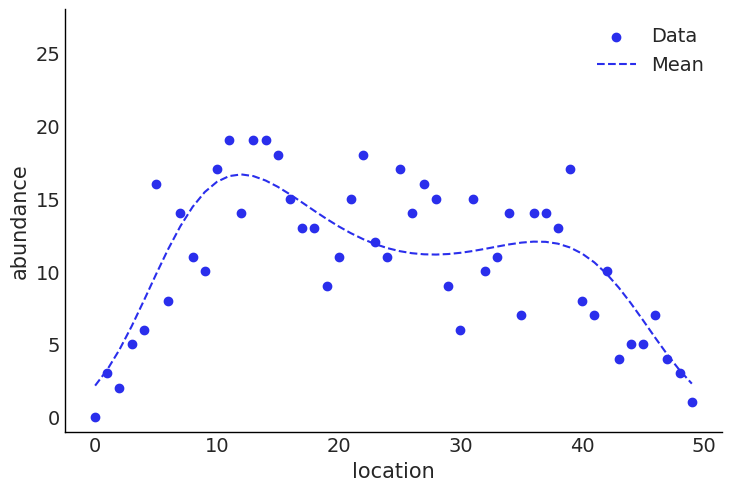

In [5]:
# データの図示
fig,ax = plt.subplots()
ax.scatter(np.arange(50),Y_data,label='Data')
ax.plot(m_data,linestyle='dashed',label='Mean')
ax.set_ylim(-1,28)
ax.set_xlabel('location')
ax.set_ylabel('abundance')
ax.legend()
plt.show()

In [6]:
# 隣接行列を生成（locationが隣のとき1）
adj_matrix = np.diagflat(np.full(len(Y_data)-1,1), k=1) + np.diagflat(np.full(len(Y_data)-1,1), k=-1)

In [7]:
print(adj_matrix.shape)

(50, 50)


In [8]:
print(adj_matrix)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]


In [9]:
# 隣接行列の1次元化
_node1, _node2 = np.where(adj_matrix==1)
node1 = _node1+1 # 要素番号0がstanでは使えないため＋1しておく
node2 = _node2+1

In [10]:
print(node1)

[ 1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12 13
 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24 25
 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36 37
 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47 48 48 49
 49 50]


In [11]:
print(node2)

[ 2  1  3  2  4  3  5  4  6  5  7  6  8  7  9  8 10  9 11 10 12 11 13 12
 14 13 15 14 16 15 17 16 18 17 19 18 20 19 21 20 22 21 23 22 24 23 25 24
 26 25 27 26 28 27 29 28 30 29 31 30 32 31 33 32 34 33 35 34 36 35 37 36
 38 37 39 38 40 39 41 40 42 41 43 42 44 43 45 44 46 45 47 46 48 47 49 48
 50 49]


## Stanで推定

In [12]:
# モデリング
stancode = """
data {
    int<lower=0> n_locaition;
    int<lower=0> n_edge;
    array[n_edge] int<lower=1, upper=n_locaition> node1;
    array[n_edge] int<lower=1, upper=n_locaition> node2;
    array[n_locaition] int<lower=0> Y;
}

parameters {
    vector[n_locaition] phi;
    real<lower=0> sigma_phi;
    real beta;
}

transformed parameters {
    vector[n_locaition] mu = exp(beta + phi*sigma_phi);
}

model {
    // ICARここから
    target += -0.5 * dot_self(phi[node1] - phi[node2]);
    sum(phi) ~ normal(0, 0.01 * n_locaition);
    // ICARここまで

    beta ~ normal(0, 10);
    sigma_phi ~ uniform(0, 100);
    Y ~ poisson(mu);
}
"""
with open('model.stan','w') as f:
  f.write(stancode)

In [13]:
from cmdstanpy import CmdStanModel

# MCMCの実行
model = CmdStanModel(stan_file=f'/content/model.stan')
fit = model.sample(
    data={
        'n_locaition':Y_data.shape[0],
        'n_edge':node1.shape[0],
        'node1':node1,
        'node2':node2,
        'Y':Y_data.astype(int)
    },
    chains=4,
    iter_warmup=1000,
    iter_sampling=1000,
    seed=1,
)
# xdarray形式にサンプルを変換
idata = az.InferenceData(posterior=fit.draws_xr())

13:23:32 - cmdstanpy - INFO - compiling stan file /content/model.stan to exe file /content/model
INFO:cmdstanpy:compiling stan file /content/model.stan to exe file /content/model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=model.stan /content/model
cwd: /root/.cmdstan/cmdstan-2.33.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=model.stan --o=/content/model.hpp /content/model.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content/model.o /content/m

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/model', 'id=1', 'random', 'seed=1', 'data', 'file=/tmp/tmp5kyjktuh/l1ophlsx.json', 'output', 'file=/tmp/tmp5kyjktuh/model__io6_7x/model-20231201132416_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/model', 'id=2', 'random', 'seed=1', 'data', 'file=/tmp/tmp5kyjktuh/l1ophlsx.json', 'output', 'file=/tmp/tmp5kyjktuh/model__io6_7x/model-20231201132416_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/model', 'id=3', 'random', 'seed=1', 'data', 'file=/tmp/tmp5kyjktuh/l1ophlsx.json', 'outpu

13:24:19 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/model', 'id=1', 'random', 'seed=1', 'data', 'file=/tmp/tmp5kyjktuh/l1ophlsx.json', 'output', 'file=/tmp/tmp5kyjktuh/model__io6_7x/model-20231201132416_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5kyjktuh/model__io6_7x/model-20231201132416_1.csv
 console_msgs (if any):
	/tmp/tmp5kyjktuh/model__io6_7x/model-20231201132416_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default

45s 1.345s

In [14]:
# 要約統計量の確認
display(az.summary(idata))

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],-3.829,1.002,-5.654,-1.991,0.026,0.019,1460.0,2162.0,1.00
phi[1],-3.343,0.885,-4.941,-1.700,0.027,0.019,1124.0,1794.0,1.00
phi[2],-2.817,0.795,-4.267,-1.355,0.024,0.017,1082.0,1562.0,1.00
phi[3],-1.979,0.732,-3.274,-0.576,0.022,0.015,1157.0,1976.0,1.00
phi[4],-1.095,0.671,-2.427,0.076,0.018,0.013,1415.0,2005.0,1.00
phi[5],-0.033,0.618,-1.126,1.131,0.015,0.011,1670.0,2151.0,1.00
phi[6],0.065,0.561,-1.012,1.115,0.011,0.008,2493.0,2387.0,1.00
phi[7],0.512,0.541,-0.499,1.531,0.011,0.008,2590.0,2832.0,1.00
phi[8],0.574,0.538,-0.403,1.603,0.012,0.009,2066.0,2154.0,1.00
phi[9],0.764,0.555,-0.285,1.790,0.013,0.010,1846.0,2045.0,1.00


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma_phi'}>,
        <Axes: title={'center': 'sigma_phi'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

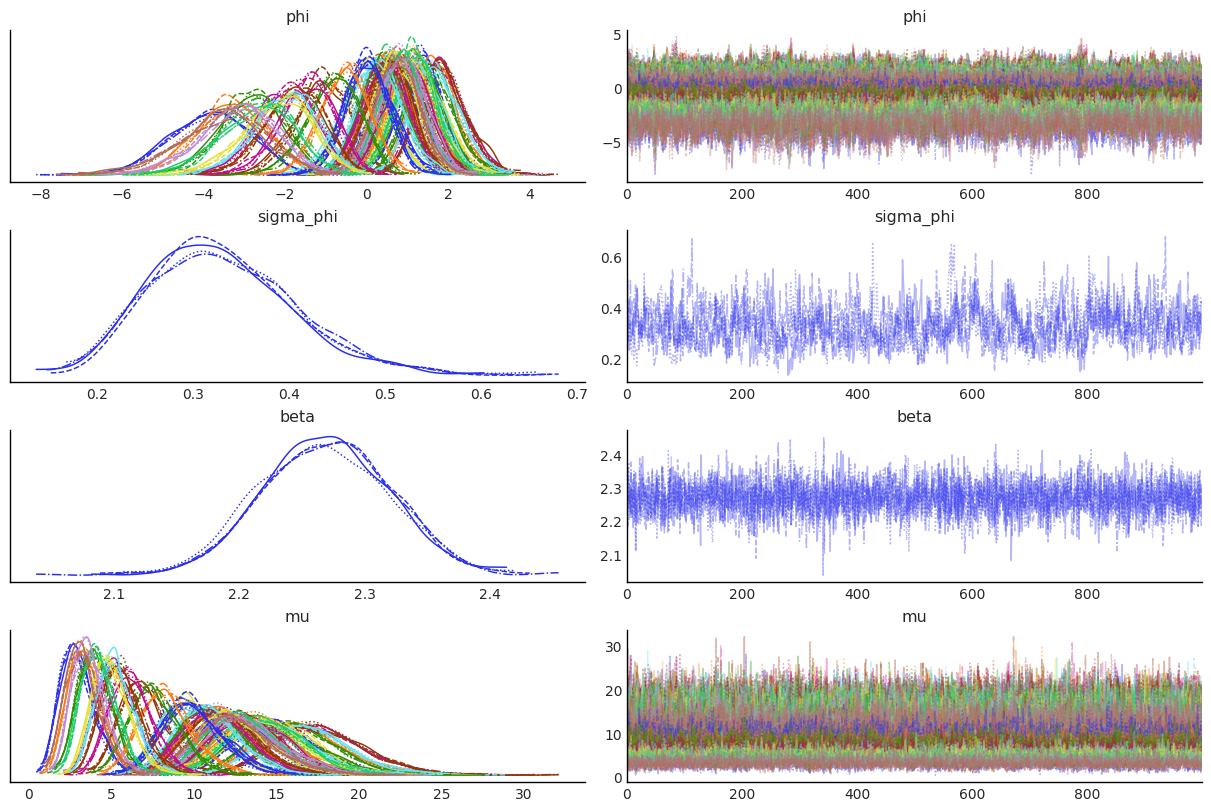

In [15]:
# トレースの確認
az.plot_trace(idata.posterior)

In [16]:
# HDIの95％信用区間
stan_hdi=az.hdi(idata.posterior['mu'],hdi_prob=0.95)
# 中央値の計算
stan_median = np.median(idata.posterior['mu'],axis=(0,1))

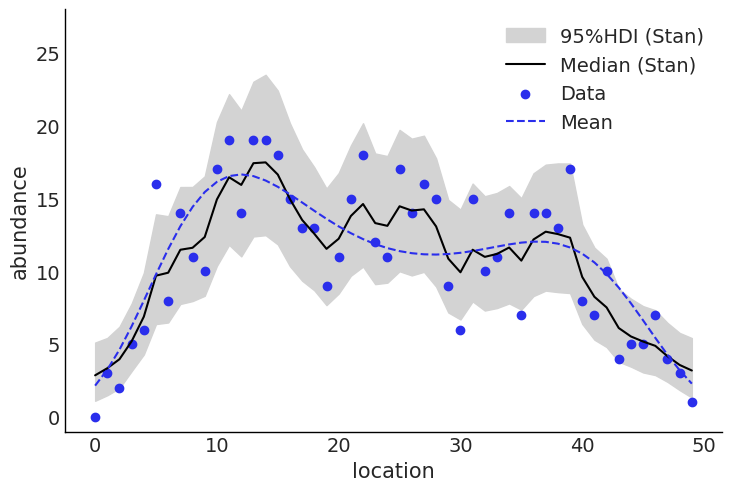

In [17]:
# 結果の図示
fig,ax = plt.subplots()
ax.fill_between(np.arange(50),stan_hdi.mu[:,1],stan_hdi.mu[:,0],color='lightgray',label='95%HDI (Stan)')
ax.plot(stan_median,color='black',label='Median (Stan)')
ax.scatter(np.arange(50),Y_data,label='Data')
ax.plot(m_data,linestyle='dashed',label='Mean')
ax.set_ylim(-1,28)
ax.set_xlabel('location')
ax.set_ylabel('abundance')
ax.legend()
plt.show()

## PyMC5で推定

In [18]:
import pymc as pm
import pytensor.tensor as pt
import pytensor

# # モデリング(再パラメータ化なし)
# class ICAR_Model(pm.Model):
#     def __init__(self, Y, location, adj_matrix):
#         super().__init__()

#         # 次元
#         self.add_coord('location', location)

#         # モデル
#         beta = pm.Normal('beta', mu=0, sigma=10)
#         sigma_phi = pm.Uniform('sigma_phi', lower=0, upper=100)
#         phi = pm.ICAR('phi', W=adj_matrix, sigma=sigma_phi, dims='location') # ICARモデル
#         mu = pm.Deterministic('mu', pt.exp(beta+phi), dims='location')
#         obs = pm.Poisson('obs', mu=mu, observed=Y, dims='location')

# モデリング(再パラメータ化あり)
class ICAR_Model(pm.Model):
    def __init__(self, Y, location, adj_matrix):
        super().__init__()

        # 次元
        self.add_coord('location', location)

        # モデル
        beta = pm.Normal('beta', mu=0, sigma=10)
        sigma_phi = pm.Uniform('sigma_phi', lower=0, upper=100)
        phi = pm.ICAR('phi', W=adj_matrix, sigma=1, dims='location') # ICARモデル
        mu = pm.Deterministic('mu', pt.exp(beta+phi*sigma_phi), dims='location')
        obs = pm.Poisson('obs', mu=mu, observed=Y, dims='location')

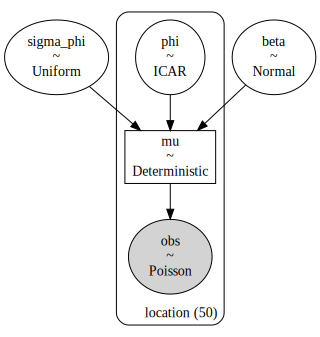

In [19]:
# モデルの図示
model = ICAR_Model(Y=Y_data, location=np.arange(Y_data.shape[0]), adj_matrix=adj_matrix)
pm.model_to_graphviz(model)

In [20]:
# MCMCの実行
idata_pymc = pm.sample(
    draws=1000,
    tune=1000,
    chains=4,
    random_seed=0,
    cores=4,
    model=model
)

590s 8m49s

In [21]:
# 要約統計量の確認
display(az.summary(idata_pymc))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,2.269,0.051,2.173,2.361,0.001,0.001,2408.0,2401.0,1.0
phi[0],-5.435,1.415,-8.233,-2.881,0.041,0.029,1179.0,1987.0,1.0
phi[1],-4.754,1.241,-7.102,-2.488,0.041,0.029,919.0,1294.0,1.0
phi[2],-3.992,1.125,-6.099,-1.920,0.037,0.026,951.0,1577.0,1.0
phi[3],-2.789,1.020,-4.799,-0.929,0.032,0.023,993.0,1893.0,1.0
phi[4],-1.530,0.928,-3.299,0.199,0.031,0.022,913.0,2016.0,1.0
phi[5],-0.040,0.863,-1.667,1.618,0.026,0.018,1145.0,2129.0,1.0
phi[6],0.084,0.786,-1.346,1.617,0.018,0.012,1991.0,2746.0,1.0
phi[7],0.731,0.769,-0.758,2.141,0.017,0.012,2181.0,2882.0,1.0
phi[8],0.809,0.781,-0.588,2.353,0.018,0.013,1967.0,2425.0,1.0


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma_phi'}>,
        <Axes: title={'center': 'sigma_phi'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

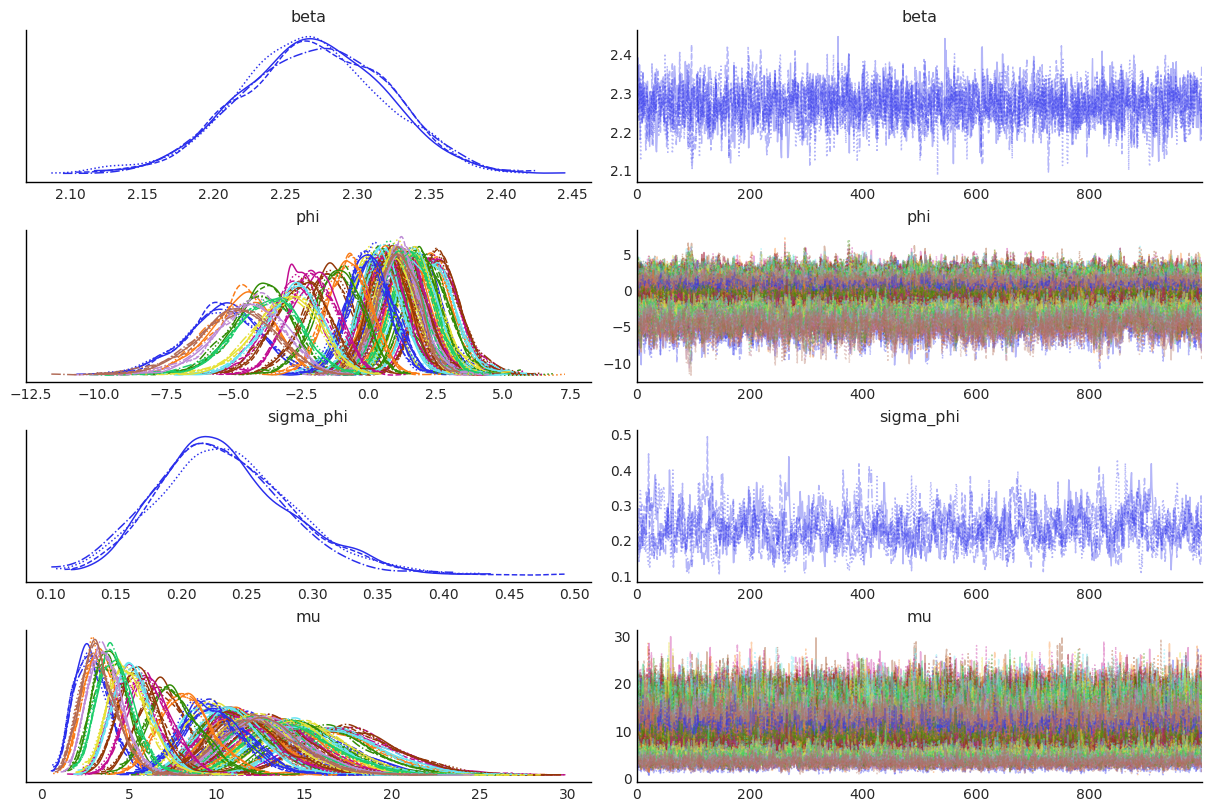

In [22]:
# トレースの確認
az.plot_trace(idata_pymc.posterior)

In [23]:
# HDIの95％信用区間
pymc_hdi=az.hdi(idata_pymc.posterior['mu'],hdi_prob=0.95)
# 中央値の計算
pymc_median = np.median(idata_pymc.posterior['mu'],axis=(0,1))

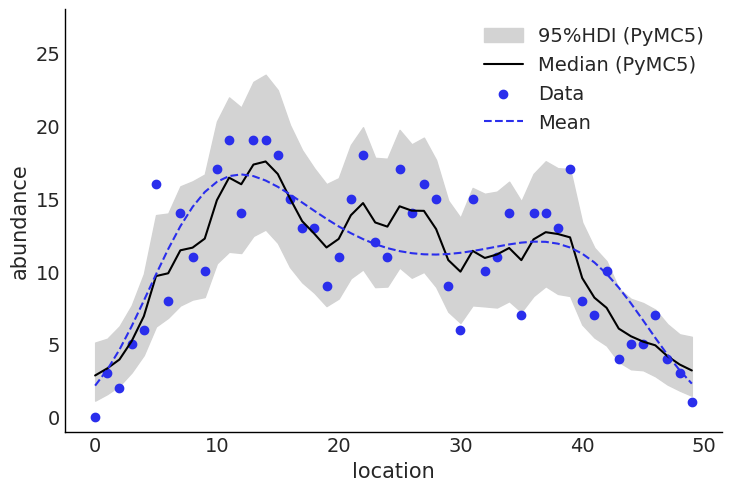

In [24]:
# 結果の図示
fig,ax = plt.subplots()
ax.fill_between(np.arange(50),pymc_hdi.mu[:,1],pymc_hdi.mu[:,0],color='lightgray',label='95%HDI (PyMC5)')
ax.plot(pymc_median,color='black',label='Median (PyMC5)')
ax.scatter(np.arange(50),Y_data,label='Data')
ax.plot(m_data,linestyle='dashed',label='Mean')
ax.set_ylim(-1,28)
ax.set_xlabel('location')
ax.set_ylabel('abundance')
ax.legend()
plt.show()